## Deriving the Allan deviation

In [57]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.fftpack import fft, fftfreq
import numpy as np
import allantools
import os

figure_path = os.path.join(os.getcwd(), "figures")
data_path = os.path.join(os.getcwd(), "laser_gyroscope_data", "allan")

In [30]:
# import data

# get only frequency and time 
data = np.genfromtxt(os.path.join(data_path, "defbuffer1_0405_161532_final.csv"), delimiter=",", skip_header=9, usecols=(0, 13))
# print(type(data[:,0]))

Text(0.5, 1.0, 'Raw data')

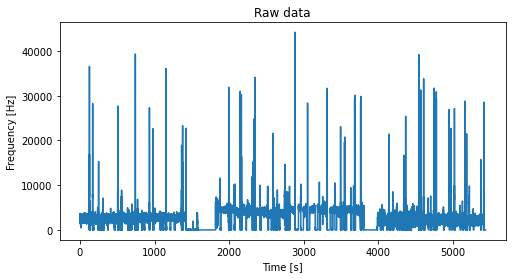

In [51]:
# plot the time series to check
freq = data[:,0]
time = data[:,1]

plt.figure(figsize=(8,4))
plt.plot(time, freq)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Raw data")

Text(0.5, 1.0, 'Filtered data')

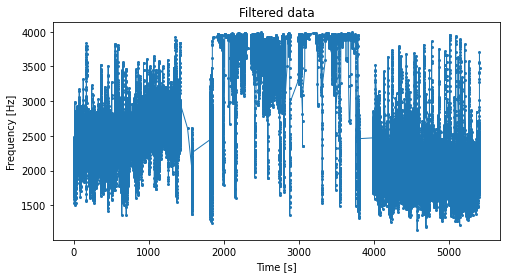

In [78]:
# remove places where the laser locked
# this is where the frequency reached zero or when it spiked, which is around freq > 4000 Hz
# or any perturbation around zero, so that we remove any frequency below 700 Hz

from scipy.ndimage import uniform_filter1d

data_filt = data[(freq < 4000) & (freq > 1000)]

freq_filt = uniform_filter1d(data_filt[:,0], size=5)
t_filt = data_filt[:,1]

plt.figure(figsize=(8,4))
plt.plot(t_filt, freq_filt, marker="o",ls="-", ms=2.0, lw=1.0)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Filtered data")


sample rate: 55.50621669626998 Hz
slope (should be ~ -1/2): -0.12986210442233004, intercept: 4.7815571228464515, A: 119.28995461643794


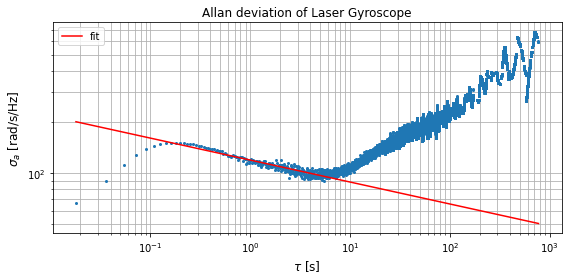

In [79]:
# determine allan deviation

# sampling rate
dt = time[1] - time[0]
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))

# get allan deviation
(t2, ad, ade, adn) = allantools.adev(freq_filt, rate=dfreq, data_type="freq", taus=t_filt)

ad_cutoff = ad[(t2 > 2e-1) & (t2 < 6)]
t2_cutoff = t2[(t2 > 2e-1) & (t2 < 6)]

# take log on both sidfes
log_allandev = np.log(ad_cutoff)
log_tau = np.log(t2_cutoff)

# perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
slope, logA = np.polyfit(log_tau, log_allandev, 1)
print("slope (should be ~ -1/2): {0}, intercept: {1}, A: {2}".format(slope, logA, np.exp(logA)))
ad_thr = np.exp(logA) * t2**slope

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.loglog(t2, ad, marker="o", ls="", ms=2.0)   # the data
ax.loglog(t2, ad_thr, color="r", zorder=3, label = 'fit')

ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
ax.set_ylabel(r"$\sigma_a$ [rad/s/Hz]", fontsize=12)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
ax.legend()
ax.grid(which='both')

sample rate: 55.50621669626998 Hz
slope (should be ~ -1/2): -0.12986210442233004, intercept: 4.7815571228464515, A: 119.28995461643794


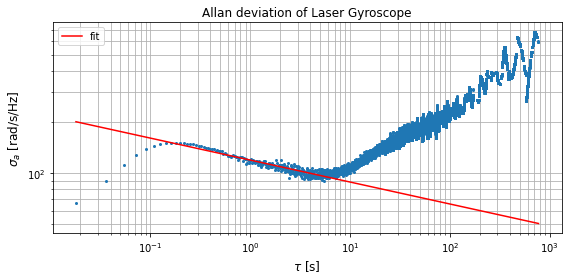

In [80]:
# determine allan deviation

# sampling rate
dt = time[1] - time[0]
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))

a = allantools.Dataset(freq_filt, taus=t_filt, rate=dfreq, data_type="freq")
result = a.compute("adev")

allan_dev = result["stat"]
tau = result["taus"]

ad_cutoff = allan_dev[(tau > 2e-1) & (tau < 6)]
tau_cutoff = tau[(tau > 2e-1) & (tau < 6)]

# take log on both sidfes
log_allandev = np.log(ad_cutoff)
log_tau = np.log(t2_cutoff)

# perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
slope, logA = np.polyfit(log_tau, log_allandev, 1)
print("slope (should be ~ -1/2): {0}, intercept: {1}, A: {2}".format(slope, logA, np.exp(logA)))
ad_thr = np.exp(logA) * tau**slope

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.loglog(tau, allan_dev, marker="o", ls="", ms=2.0)   # the data
ax.loglog(tau, ad_thr, color="r", zorder=3, label = 'fit')

ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
ax.set_ylabel(r"$\sigma_a$ [rad/s/Hz]", fontsize=12)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
ax.legend()
ax.grid(which='both')